# Postprocessing for the eigenvalue solutions

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, h5py
from pg_utils.processing import postproc as pproc

## Matrix visualization

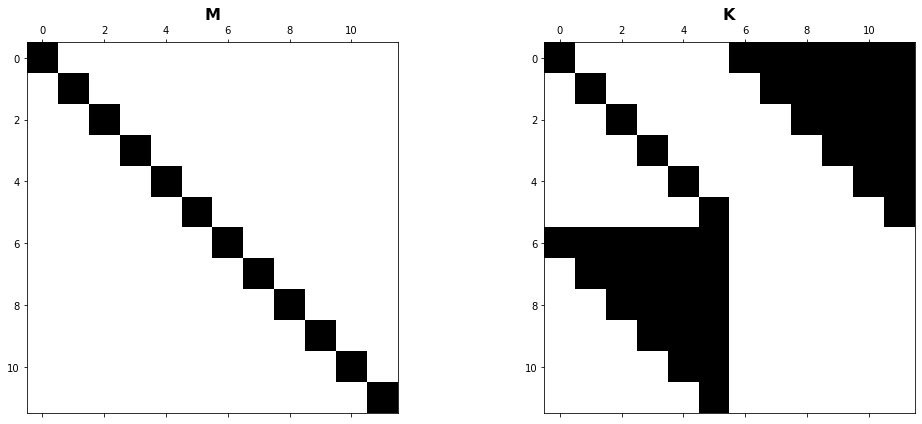

In [71]:
with h5py.File("./out/cases/Malkus/Reduced_sys/Matrix_eval.h5", 'r') as fread:
    M_tmp = fread["M"][()]
    K_tmp = fread["K"][()]

visual_prec = 1e-10
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.spy(M_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{M}$", fontsize=16)

ax = axes[1]
ax.spy(K_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{K}$", fontsize=16)

plt.tight_layout()
# plt.savefig("./out/imgs/sparsity__recipe_reduced_value_tiny.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Compare eigenvalues

Read in eigenvalue solutions

In [32]:
solution_file_list = [
    # "./out/solutions/Malkus/Eigen_recipe-Daria_mm.hdf5", 
    # "./out/solutions/Malkus/Eigen_recipe-Daria.h5", 
    # "./out/solutions/Malkus/Eigen_recipe-Daria_scipy.h5", 
    # "./out/cases/Malkus/MM_recipe/Eigen.h5",
    # "./out/cases/Malkus/MM_quad_Malkus/Eigen.h5",
    "./out/cases/Malkus/Full_recipe_Daria_thesis/Eigen.h5",
    "./out/cases/Malkus/Conjugate_recipe/Eigen.h5", 
    "./out/cases/Malkus/Reduced_sys/Eigen.h5"
]
src_names = [
    # "Code Daria Mathematica", 
    # "PlesioGeostroPy-mp32", 
    # "PlesioGeostroPy-scipy", 
    # "PlesioGeostroPy-PG-Daria",
    # "PlesioGeostroPy: Recipe Daria quad_Malkus",
    "Recipe Holdenried-Chernoff (2021)",
    "Conjugate variables", 
    "Reduced system"
]

solution_list = list()
for idx, fname in enumerate(solution_file_list):
    with h5py.File(fname, 'r') as f:
        solution_list.append(f["eigval"][()])

if "Mathematica" in src_names[0].split():
    solution_list[0] = 1j*solution_list[0]

Sort east/west modes

In [33]:
df_east = pd.DataFrame()
df_west = pd.DataFrame()

for idx, srcname in enumerate(src_names):
    eig_val_tmp = solution_list[idx]
    eigidx_east = np.arange(eig_val_tmp.size)[np.imag(eig_val_tmp) < -1e-3]
    eigidx_west = np.arange(eig_val_tmp.size)[np.imag(eig_val_tmp) > +1e-3]
    df_east[srcname] = eig_val_tmp[eigidx_east]
    df_west[srcname] = np.flip(eig_val_tmp[eigidx_west])

Load analytical

In [34]:
from pg_utils.numerics import utils as nutils

n_eigs = np.arange(1, 7)
omega_fast, omega_slow = nutils.eigenfreq_Malkus_pg(3, n_eigs, 1e-4, mode="all", timescale="alfven")

df_east["Analytic PG"] = omega_fast*1j
df_west["Analytic PG"] = omega_slow*1j

omega_fast, omega_slow = nutils.eigenfreq_Malkus_3d(3, n_eigs, 1e-4, mode="all", timescale="alfven")

df_east["Analytic 3D"] = omega_fast*1j
df_west["Analytic 3D"] = omega_slow*1j

Output

In [35]:
df_east.transpose().style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.7e}j".format(x))

,0,1,2,3,4,5
Recipe Holdenried-Chernoff (2021),"0.00e+00,-2.3529453e+03j","7.12e-21,-1.1650566e+03j","2.62e-21,-7.0176751e+02j","5.46e-14,-4.7060766e+02j","1.55e-14,-3.3805509e+02j","2.01e-15,-2.5481277e+02j"
Conjugate variables,"0.00e+00,-2.3529453e+03j","-1.65e-24,-1.1650566e+03j","-2.27e-13,-7.0176751e+02j","-5.69e-14,-4.7060766e+02j","-5.69e-14,-3.3805509e+02j","8.88e-16,-2.5481271e+02j"
Reduced system,"0.00e+00,-2.3529453e+03j","2.27e-13,-1.1650566e+03j","1.35e-13,-7.0176751e+02j","-2.15e-14,-4.7060766e+02j","-1.46e-14,-3.3805509e+02j","6.45e-14,-2.5481269e+02j"
Analytic PG,"-0.00e+00,-2.3529453e+03j","-0.00e+00,-1.1650566e+03j","-0.00e+00,-7.0176751e+02j","-0.00e+00,-4.7060766e+02j","-0.00e+00,-3.3805509e+02j","-0.00e+00,-2.5481269e+02j"
Analytic 3D,"-0.00e+00,-2.5319765e+03j","-0.00e+00,-1.1874052e+03j","-0.00e+00,-7.0680028e+02j","-0.00e+00,-4.7215532e+02j","-0.00e+00,-3.3863603e+02j","-0.00e+00,-2.5506357e+02j"


In [36]:
df_west.transpose().style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.6e}j".format(x))

,0,1,2,3,4,5
Recipe Holdenried-Chernoff (2021),"-1.01e-15,4.124993e-03j","8.91e-15,8.024945e-03j","-1.34e-14,1.312475e-02j","9.76e-15,1.942420e-02j","-1.79e-14,2.692286e-02j","-6.95e-15,3.570488e-02j"
Conjugate variables,"2.02e-16,4.124993e-03j","1.06e-15,8.024945e-03j","2.25e-15,1.312475e-02j","4.48e-15,1.942420e-02j","1.24e-15,2.692286e-02j","-4.23e-15,3.564420e-02j"
Reduced system,"-1.74e-14,4.124993e-03j","1.36e-17,8.024945e-03j","-6.86e-17,1.312475e-02j","2.07e-16,1.942420e-02j","5.63e-17,2.692286e-02j","8.81e-16,3.562002e-02j"
Analytic PG,"0.00e+00,4.124993e-03j","0.00e+00,8.024945e-03j","0.00e+00,1.312475e-02j","0.00e+00,1.942420e-02j","0.00e+00,2.692286e-02j","0.00e+00,3.562002e-02j"
Analytic 3D,"0.00e+00,3.854535e-03j","0.00e+00,7.879550e-03j","0.00e+00,1.303344e-02j","0.00e+00,1.936151e-02j","0.00e+00,2.687718e-02j","0.00e+00,3.558528e-02j"


Plotting

,0,1,2,3,4,5
Recipe Holdenried-Chernoff (2021),9.663e-16,7.806e-16,3.240e-16,9.732e-16,1.743e-16,3.330e-07
Conjugate variables,0.000e+00,3.903e-16,3.622e-16,1.708e-16,1.189e-15,9.490e-08
Reduced system,3.865e-16,9.951e-16,6.761e-16,8.467e-16,5.063e-16,8.208e-16


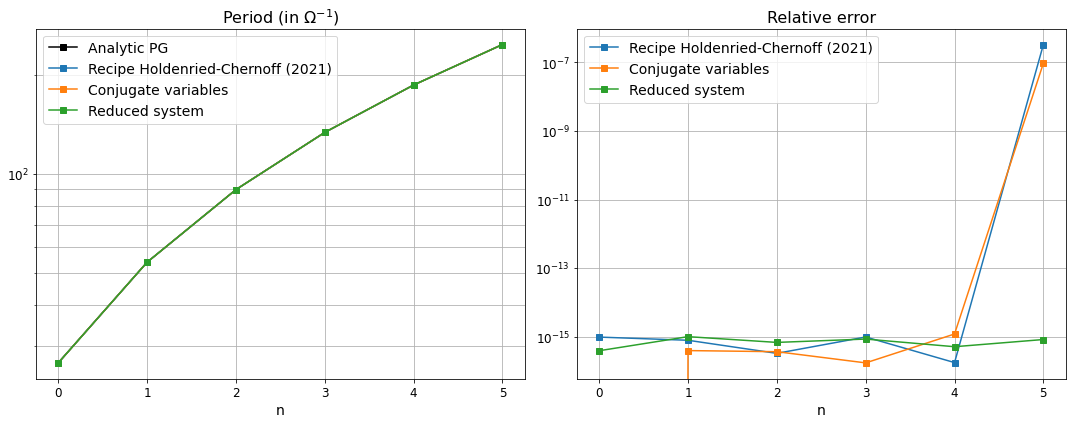

In [39]:
df_compare = df_east
compare_ref = "Analytic PG"
save_name = "./out/imgs/err_comparison_east"
# save_name = None
override = True

df_compare_err = pd.DataFrame()
for idx, srcname in enumerate(src_names):
    df_compare_err[srcname] = np.abs(df_compare[compare_ref] - df_compare[srcname])/np.abs(df_east[compare_ref])
display(df_compare_err.transpose().style.format(formatter=lambda x: "{:.3e}".format(x)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.semilogy(np.arange(6), 2*np.pi*1e+4/np.abs(np.imag(df_compare[compare_ref])), 'ks-', label=compare_ref)
for idx, srcname in enumerate(src_names):
    ax.semilogy(np.arange(6), 2*np.pi*1e+4/np.abs(np.imag(df_compare[srcname])), 's-', label=srcname)
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_xlabel("n", fontsize=14)
ax.set_title("Period (in $\Omega^{-1}$)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax = axes[1]
for idx, srcname in enumerate(src_names):
    ax.semilogy(np.arange(6), df_compare_err[srcname], 's-', label=srcname)
ax.grid(which="major")
ax.legend(fontsize=14)
ax.set_xlabel("n", fontsize=14)
ax.set_title("Relative error", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.pdf') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.pdf', format="pdf", bbox_inches="tight")
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")
plt.show()

## Eigenmode visualization

Select a file to start

In [36]:
from pg_utils.pg_model import core, base, params
from pg_utils.pg_model import expansion as xpd
from pg_utils.numerics import matrices as nmatrix


eigenfile = "./out/cases/Malkus/Full_recipe_Daria_thesis/Eigen.h5"
from pg_utils.pg_model import expand_daria_thesis as xpd_cfg

with h5py.File(eigenfile, 'r') as fread:
    xpd_identifier = fread.attrs["xpd"]
    azm_val = fread.attrs["azm"]
    Le_val = fread.attrs["Le"]
    Lu_val = fread.attrs["Lu"]
    cnames = list(fread["bases"]["names"].asstr()[()])
    ranges_trial = fread["bases"]["ranges"][()]
    eig_vals = fread["eigval"][()]
    eig_vecs = fread["eigvec"][()]

# Sort east-west modes
eigidx_east = np.arange(eig_vals.size)[np.imag(eig_vals) < -1e-7]
eigidx_west = np.arange(eig_vals.size)[np.imag(eig_vals) > +1e-7]
eigval_east = eig_vals[eigidx_east]
eigval_west = eig_vals[eigidx_west]
eigvec_east = eig_vecs[:, eigidx_east]
eigvec_west = eig_vecs[:, eigidx_west]

fnames = xpd_cfg.field_names

# Physical params
physical_params = {
    core.t: 0,
    xpd.m: azm_val,
    params.Le: Le_val
}

# Expansion range
field_nrange = {fname: ranges_trial[i_field] for i_field, fname in enumerate(fnames)}
field_nrange["U_s"] = field_nrange["Psi"]
field_nrange["U_p"] = field_nrange["Psi"]
field_nrange["U_z"] = field_nrange["Psi"]
field_nrange["Zeta"] = field_nrange["Psi"]

In [37]:
xpd_cfg.identifier, xpd_identifier

('expand_daria_thesis_mode_eigen', 'expand_daria_thesis_mode_eigen')

Configure the expansion

In [38]:
field_func = pproc.get_eigen_field_function(xpd_cfg.recipe, physical_params)

Select an eigenvalue to visualize

In [39]:
mode, idx = "fast", 5
if mode == "fast":
    eigval, eigvec = eigval_east[idx], eigvec_east[:, idx]
elif mode == "slow":
    eigval, eigvec = eigval_west[idx], eigvec_west[:, idx]

eigvec = nmatrix.LabeledBlockArray(eigvec, cnames, ranges_trial)
eigvec = base.LabeledCollection(cnames, 
    **{cname: eigvec[cname] for cname in cnames})
map_coeff_vals = base.map_collection(xpd_cfg.recipe.rad_xpd.coeffs, eigvec)

### Radial plot

For radial plot, $\phi=Cst$, $z=Cst$.

In [40]:
p_cst = np.pi/4
z_cst = 0
s_array = np.linspace(0, 1, num=100)

Alternatively, one can use a list of s points corresponding to spacing in $\xi$

In [41]:
from scipy import special as specfun

xi_array, _ = specfun.roots_chebyt(100)
s_array = np.sqrt((1 + xi_array)/2)

Calculate all fields

In [7]:
def calc_field_rad(fname, field_f):
    S_mesh, N_mesh = np.meshgrid(s_array, field_nrange[fname], indexing='ij')
    eval_tmp = field_f(S_mesh, p_cst, z_cst, N_mesh, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

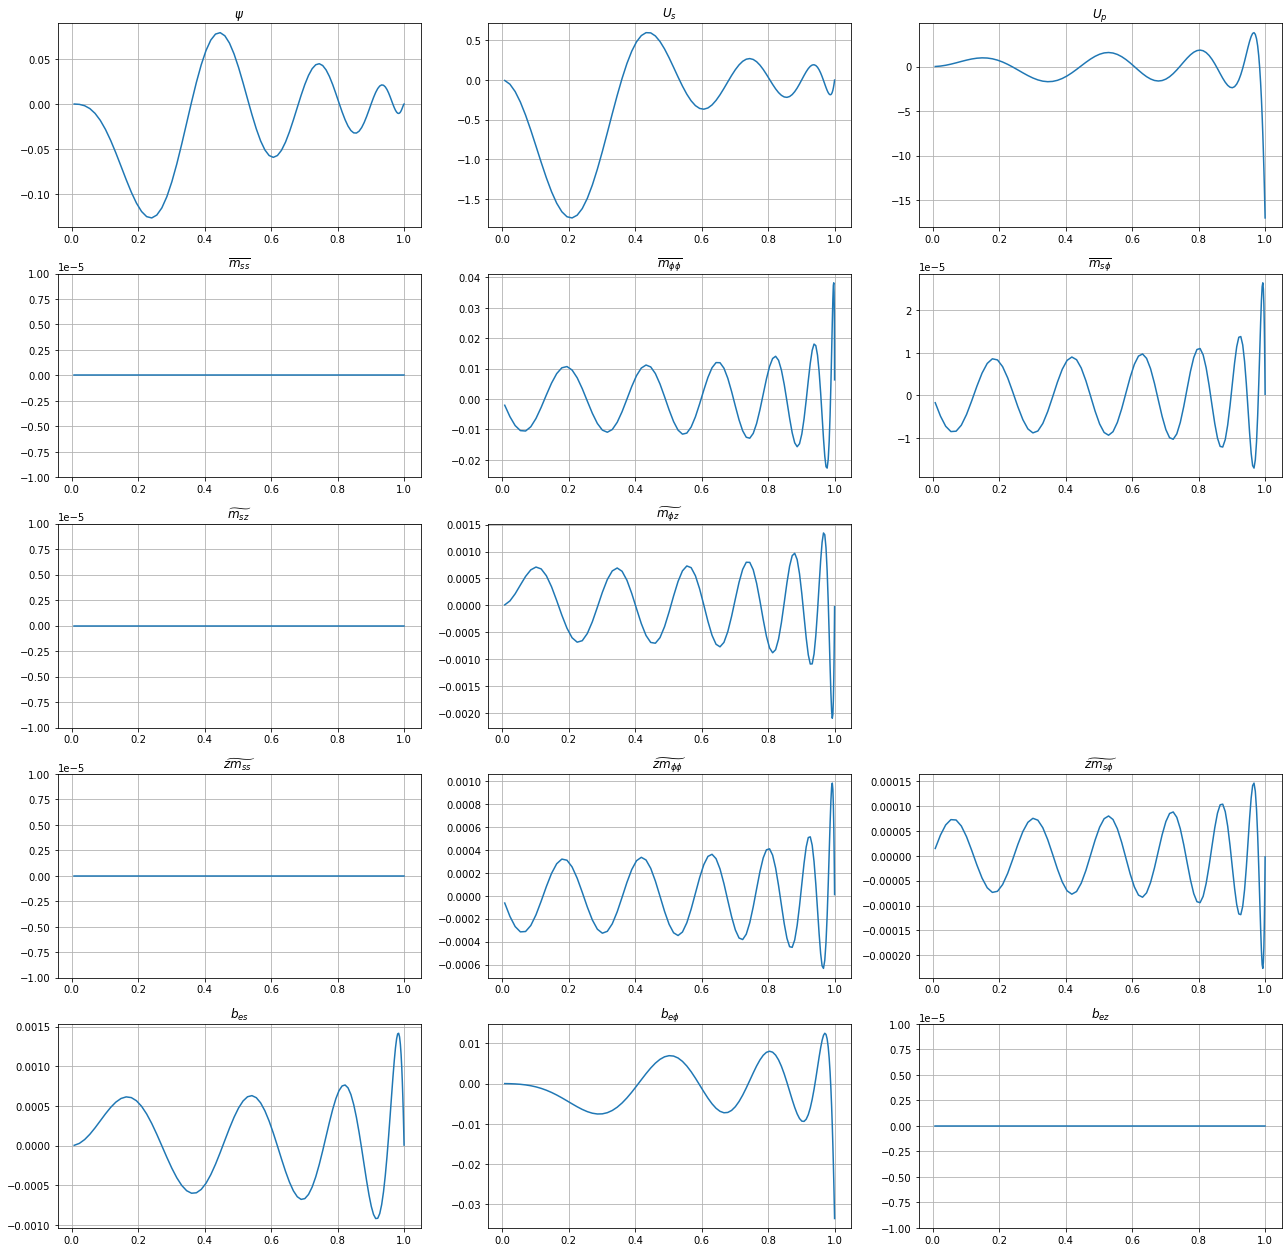

In [8]:
plot_fields = [["Psi", "U_s", "U_p"],
               ["Mss", "Mpp", "Msp"], 
               ["Msz", "Mpz", None], 
               ["zMss", "zMpp", "zMsp"], 
               ["Bs_e", "Bp_e", "Bz_e"]]

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*3.5))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        ax.plot(s_array, np.real(eigmode_eval[fname]))
        if np.abs(np.real(eigmode_eval[fname])).max() < 1e-5:
            ax.set_ylim([-1e-5, +1e-5])
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar_ptb[fname].name,))
        else:
            ax.set_title(r'$%s$' % (fname,))
        ax.grid(True)

plt.tight_layout()
plt.show()

### Equatorial plane plot

For Equatorial plane section, $z=0$. $s$ and $p$ form a mesh of grid points.

In [42]:
z_cst = 0
s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, np.pi/2, num=100)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

Calculate all fields

In [43]:
def calc_field_rad(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([P_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, z_cst, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

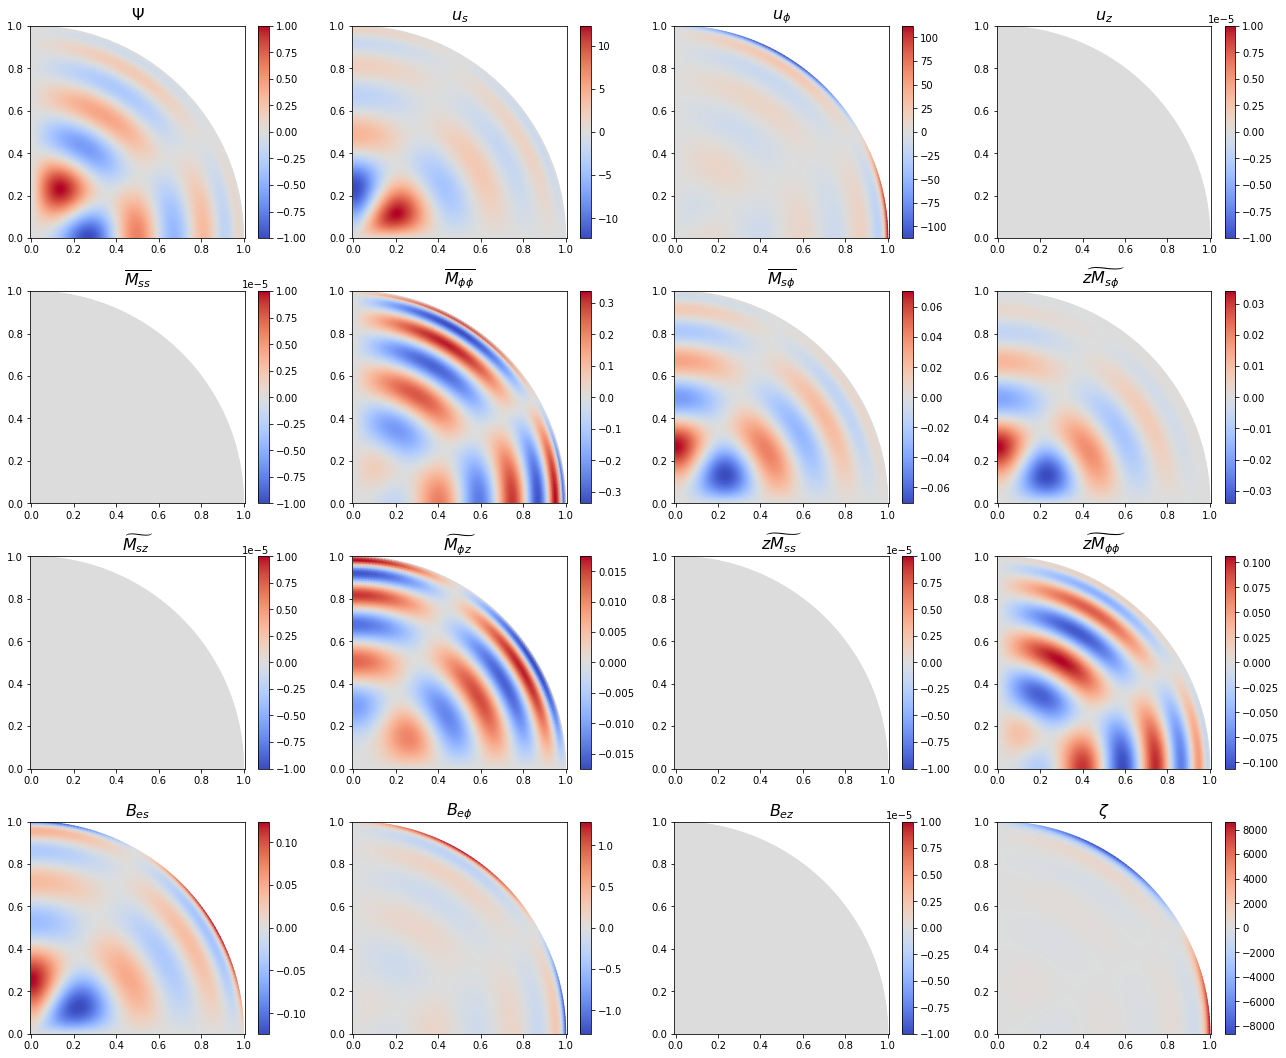

In [44]:
plot_fields = [["Psi", "U_s", "U_p", "U_z"],
               ["Mss", "Mpp", "Msp", "zMsp"], 
               ["Msz", "Mpz", "zMss", "zMpp"], 
               ["Bs_e", "Bp_e", "Bz_e", "Zeta"]]
plot_fnames = [[None, r"$u_s$", r"$u_\phi$", r"$u_z$"],
               [None, None, None, None], 
               [None, None, None, None], 
               [None, None, None, r"$\zeta$"]]
save_name = None
# save_name = "./out/solutions/Malkus/m3n5_sympy_eqplot"
save_name = "./out/cases/Malkus/Full_recipe_Daria_thesis/m3n5_eqplot"
override = False

# max_norm = max([np.abs(np.real(eigmode_eval[plot_fields[i_r][i_c]])).max() 
#                 for i_r in range(nrows) for i_c in range(ncols) 
#                 if plot_fields[i_r][i_c] is not None and plot_fields[i_r][i_c] != "Zeta"])
max_norm = np.abs(np.real(eigmode_eval["Psi"])).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.7))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # if fname in core.pgvar._field_names:
        #     ax.set_title(r'$%s$' % (core.pgvar[fname].name,))
        # else:
        #     ax.set_title(fname)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

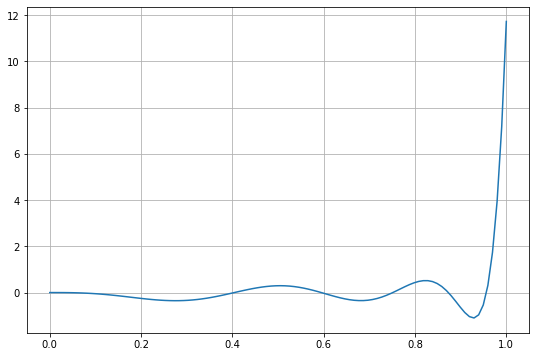

In [28]:
from scipy import special as specfun

s_rad = np.linspace(0, 1, num=100)
zeta_func = s_rad**3*specfun.eval_jacobi(5, 3/2, 3, 2*s_rad**2 - 1)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(s_rad, zeta_func)
# ax.set_yscale("symlog")
ax.grid(which="both")

plt.savefig("./presentation/elements/vorticity_radial_m3n5.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Meridional plane plot

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [22]:
p_cst = np.pi/4
r_array = np.linspace(0, 1, num=100)
theta_array = np.linspace(0, np.pi/2, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(P_mesh), R_mesh*np.cos(P_mesh)

Calculate all fields

In [23]:
def calc_field_rad(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, p_cst, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

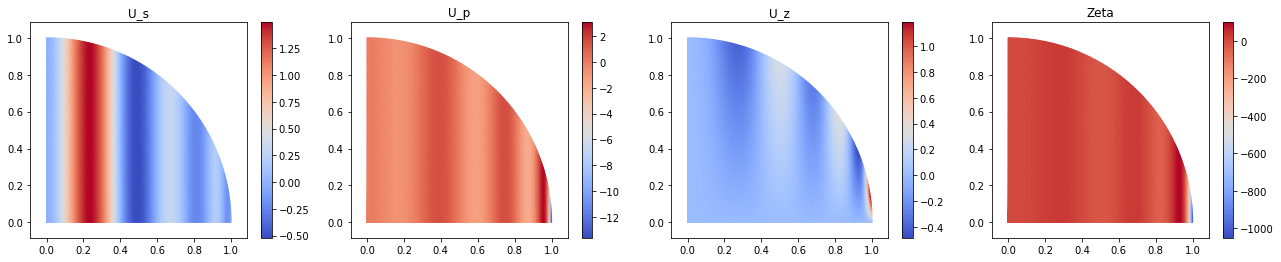

In [24]:
plot_fields = [["U_s", "U_p", "U_z", "Zeta"],]
# save_name = "./out/solutions/Malkus/m3n5_sympy_mdplot"
save_name = None
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.75))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.real(eigmode_eval[fname]).max() > 1e-5:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,))
        else:
            ax.set_title(fname)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Output to 3-D visualization

In [115]:
r_array = np.arange(0.05, 1, 0.1)
theta_array = np.arange(0, 181, 5)
phi_array = np.arange(0, 360, 5)

R_mesh, Phi_mesh, Theta_mesh = np.meshgrid(r_array, np.radians(phi_array), np.radians(theta_array), indexing='ij')
S_mesh = R_mesh*np.sin(Theta_mesh)
Z_mesh = R_mesh*np.cos(Theta_mesh)

def calc_field_3d(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Phi_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

Zeta_mesh = calc_field_3d("Zeta", field_func.Zeta)
Uz_mesh = calc_field_3d("U_z", field_func.U_z)

In [117]:
np.savez("./out/cases/Malkus/3darray.npz", r_array=r_array, theta_array=theta_array, phi_array=phi_array, Zeta=Zeta_mesh, Uz=Uz_mesh)

In [115]:
r_array = np.arange(0.05, 1, 0.1)
theta_array = np.arange(0, 181, 5)
phi_array = np.arange(0, 360, 5)

R_mesh, Phi_mesh, Theta_mesh = np.meshgrid(r_array, np.radians(phi_array), np.radians(theta_array), indexing='ij')
S_mesh = R_mesh*np.sin(Theta_mesh)
Z_mesh = R_mesh*np.cos(Theta_mesh)

def calc_field_3d(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Phi_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

Zeta_mesh = calc_field_3d("Zeta", field_func.Zeta)
Uz_mesh = calc_field_3d("U_z", field_func.U_z)

In [117]:
np.savez("./out/cases/Malkus/3darray.npz", r_array=r_array, theta_array=theta_array, phi_array=phi_array, Zeta=Zeta_mesh, Uz=Uz_mesh)

## Conjugate eigenmode visualization

Select a file to start

In [45]:
from pg_utils.pg_model import core, base, params
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import expand_conjugate as xpd_cfg
from pg_utils.numerics import matrices as nmatrix


eigenfile = "./out/cases/Malkus/Conjugate_recipe/Eigen.h5"

with h5py.File(eigenfile, 'r') as fread:
    xpd_identifier = fread.attrs["xpd"]
    azm_val = fread.attrs["azm"]
    Le_val = fread.attrs["Le"]
    Lu_val = fread.attrs["Lu"]
    cnames = list(fread["bases"]["names"].asstr()[()])
    ranges_trial = fread["bases"]["ranges"][()]
    eig_vals = fread["eigval"][()]
    eig_vecs = fread["eigvec"][()]

# Sort east-west modes
eigidx_east = np.arange(eig_vals.size)[np.imag(eig_vals) < -1e-7]
eigidx_west = np.arange(eig_vals.size)[np.imag(eig_vals) > +1e-7]
eigval_east = eig_vals[eigidx_east]
eigval_west = eig_vals[eigidx_west]
eigvec_east = eig_vecs[:, eigidx_east]
eigvec_west = eig_vecs[:, eigidx_west]

# fnames = xpd_cfg.field_names
fnames = base.CollectionPG.pg_field_names

# Physical params
physical_params = {
    core.t: 0,
    xpd.m: azm_val,
    params.Le: Le_val
}

# Expansion range
field_nrange = {fname: ranges_trial[1] if 'M' in fname else ranges_trial[0] for fname in fnames}
field_nrange["U_s"] = field_nrange["Psi"]
field_nrange["U_p"] = field_nrange["Psi"]
field_nrange["U_z"] = field_nrange["Psi"]
field_nrange["Zeta"] = field_nrange["Psi"]

Configure the expansion

In [46]:
field_func = pproc.eigen_func_from_conjugate(xpd_cfg.recipe, physical_params)

Select an eigenvalue to visualize

In [47]:
mode, idx = "fast", 5
if mode == "fast":
    eigval, eigvec = eigval_east[idx], eigvec_east[:, idx]
elif mode == "slow":
    eigval, eigvec = eigval_west[idx], eigvec_west[:, idx]

eigvec = nmatrix.LabeledBlockArray(eigvec, cnames, ranges_trial)
eigvec = base.LabeledCollection(cnames, 
    **{cname: eigvec[cname] for cname in cnames})
map_coeff_vals = base.map_collection(xpd_cfg.recipe.rad_xpd.coeffs, eigvec)

### Radial plot

For radial plot, $\phi=Cst$, $z=Cst$.

In [48]:
p_cst = np.pi/4
z_cst = 0
s_array = np.linspace(0, 1, num=100)

Alternatively, one can use a list of s points corresponding to spacing in $\xi$

In [49]:
from scipy import special as specfun

xi_array, _ = specfun.roots_chebyt(100)
s_array = np.sqrt((1 + xi_array)/2)

Calculate all fields

In [31]:
def calc_field_rad(fname, field_f):
    # print(fname)
    S_mesh, N_mesh = np.meshgrid(s_array, np.arange(field_nrange[fname]), indexing='ij')
    eval_tmp = field_f(S_mesh, p_cst, z_cst, N_mesh, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

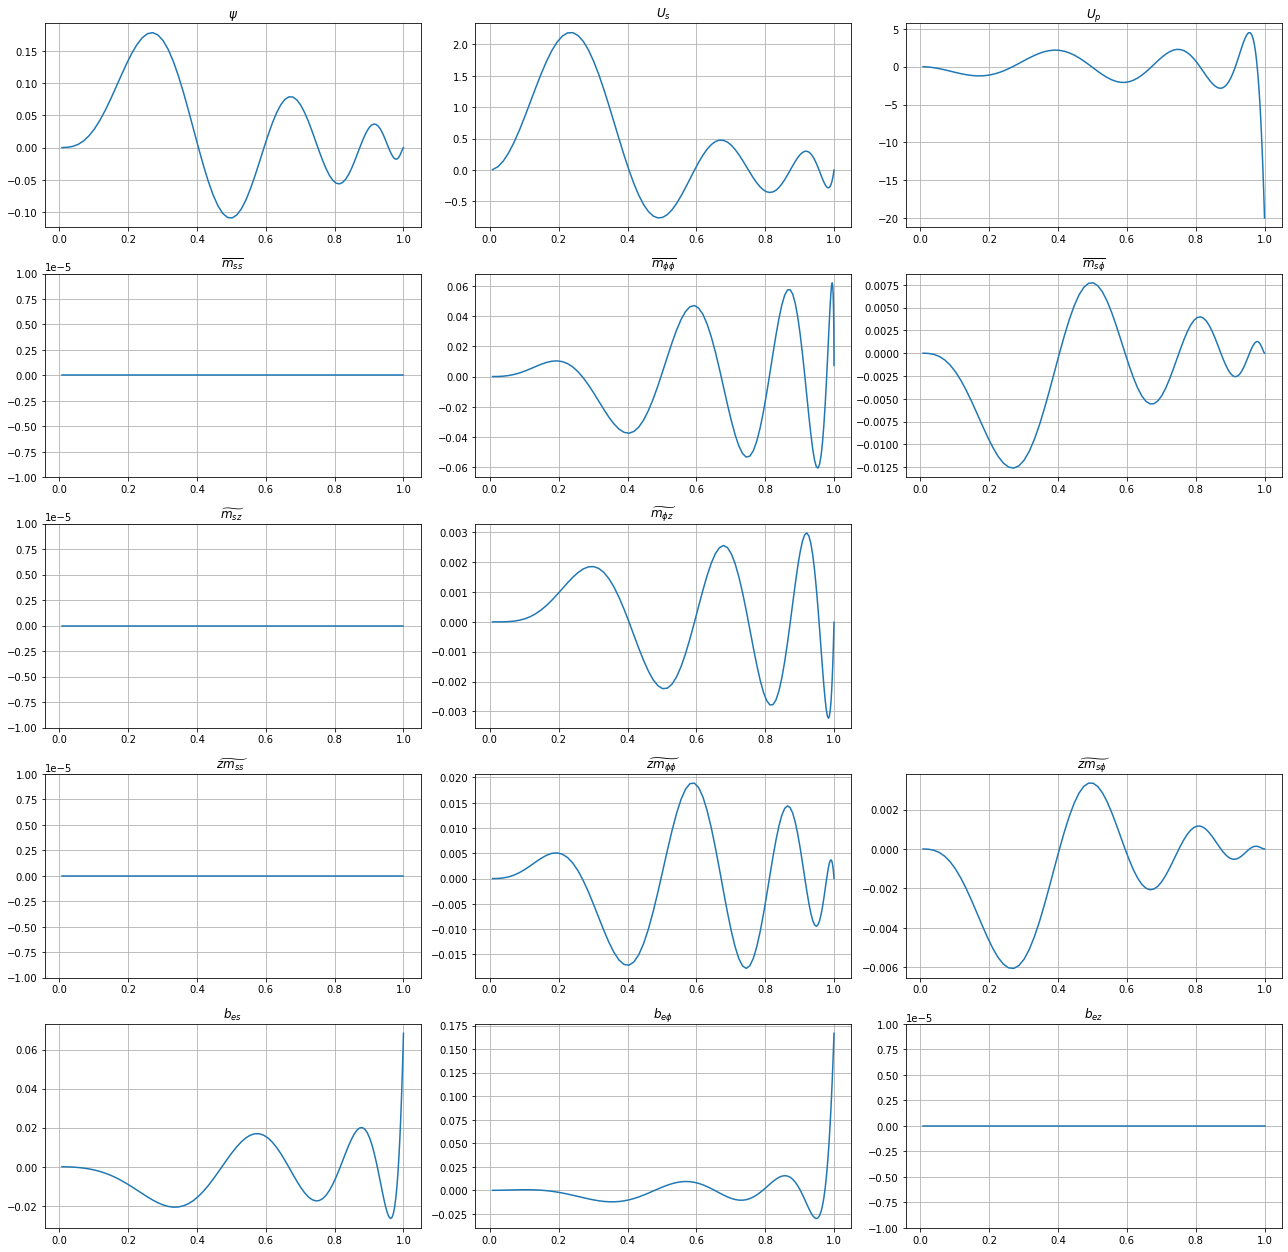

In [32]:
plot_fields = [["Psi", "U_s", "U_p"],
               ["Mss", "Mpp", "Msp"], 
               ["Msz", "Mpz", None], 
               ["zMss", "zMpp", "zMsp"], 
               ["Bs_e", "Bp_e", "Bz_e"]]

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*3.5))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        ax.plot(s_array, np.real(eigmode_eval[fname]))
        if np.abs(np.real(eigmode_eval[fname])).max() < 1e-5:
            ax.set_ylim([-1e-5, +1e-5])
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar_ptb[fname].name,))
        else:
            ax.set_title(r'$%s$' % (fname,))
        ax.grid(True)

plt.tight_layout()
plt.show()

### Equatorial plane plot

For Equatorial plane section, $z=0$. $s$ and $p$ form a mesh of grid points.

In [50]:
z_cst = 0
s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, np.pi/2, num=100)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

Calculate all fields

In [51]:
def calc_field_equatorial(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([P_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, z_cst, N_tmp, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_equatorial, inplace=False, metadata=True)

Plot all fields

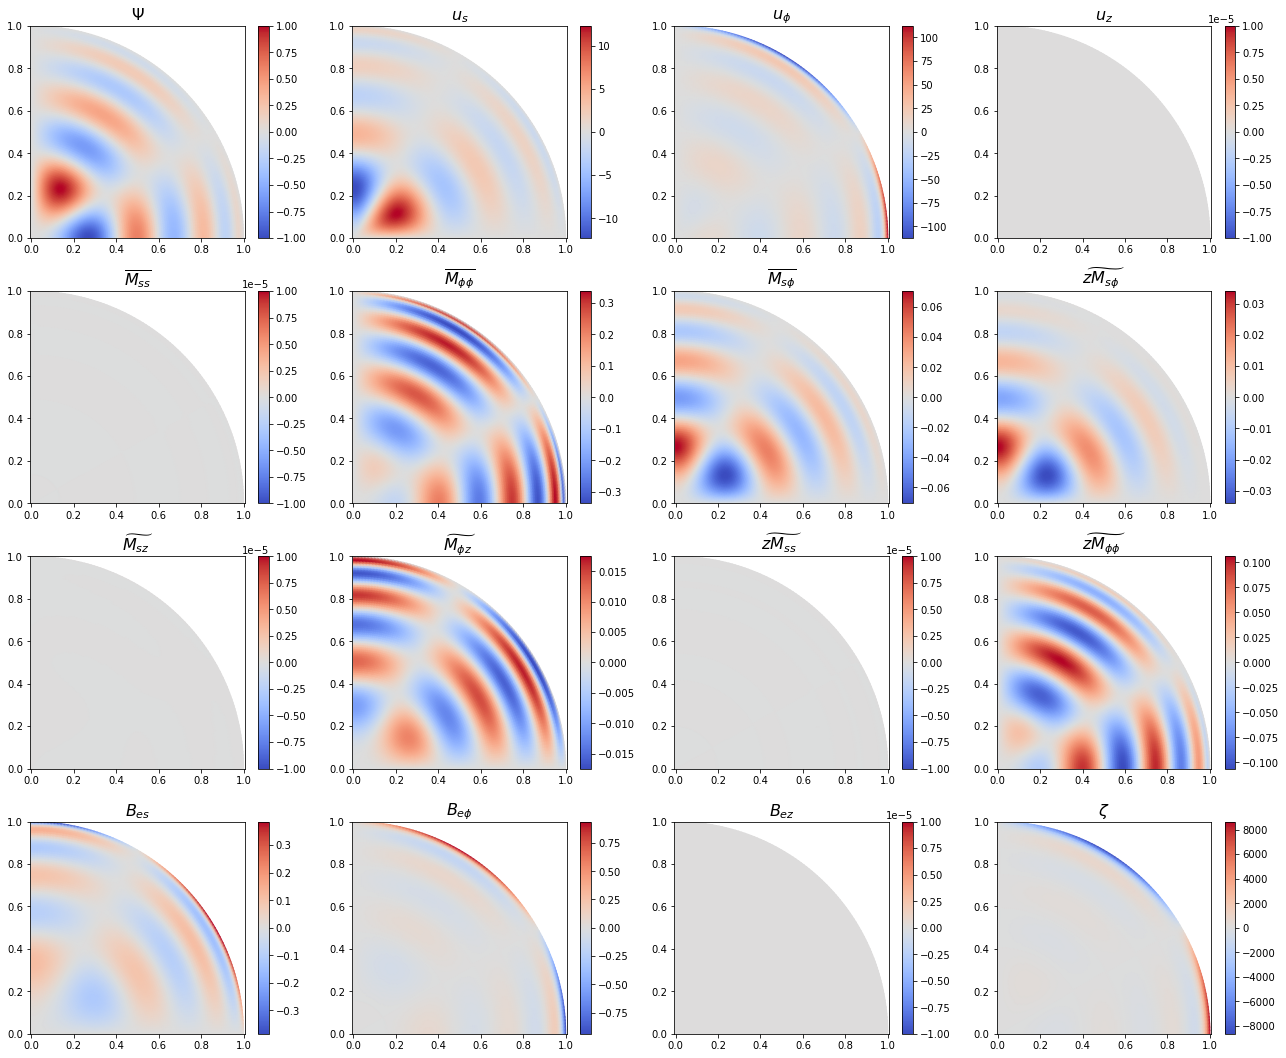

In [53]:
plot_fields = [["Psi", "U_s", "U_p", "U_z"],
               ["Mss", "Mpp", "Msp", "zMsp"], 
               ["Msz", "Mpz", "zMss", "zMpp"], 
               ["Bs_e", "Bp_e", "Bz_e", "Zeta"]]
plot_fnames = [[None, r"$u_s$", r"$u_\phi$", r"$u_z$"],
               [None, None, None, None], 
               [None, None, None, None], 
               [None, None, None, r"$\zeta$"]]
save_name = None
save_name = "./out/cases/Malkus/Conjugate_recipe/m3n5_eqplot"
override = False

# max_norm = max([np.abs(np.real(eigmode_eval[plot_fields[i_r][i_c]])).max() 
#                 for i_r in range(nrows) for i_c in range(ncols) 
#                 if plot_fields[i_r][i_c] is not None and plot_fields[i_r][i_c] != "Zeta"])
max_norm = np.abs(np.real(eigmode_eval["Psi"])).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.7))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Meridional plane plot

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [45]:
p_cst = np.pi/4
r_array = np.linspace(0, 1, num=100)
theta_array = np.linspace(0, np.pi/2, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(T_mesh), R_mesh*np.cos(T_mesh)

Calculate all fields

In [46]:
def calc_field_meridional(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, p_cst, Z_tmp, N_tmp, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_meridional, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

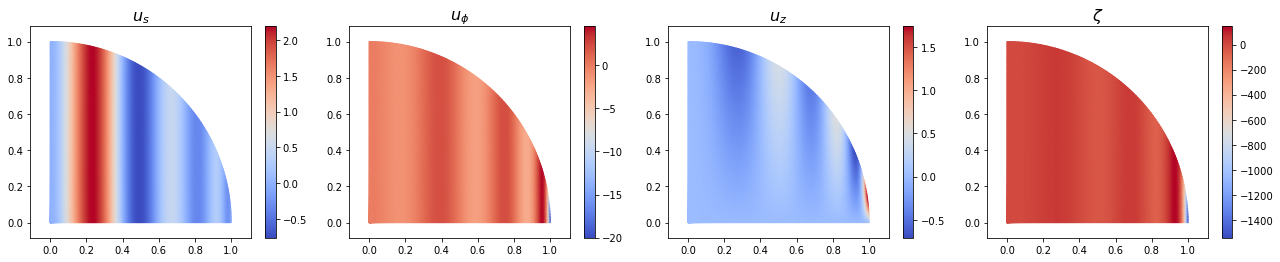

In [47]:
plot_fields = [["U_s", "U_p", "U_z", "Zeta"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$", r"$\zeta$"],]
save_name = None
# save_name = "./out/cases/Malkus/Conjugate_recipe/m3n5_sympy_mdplot"
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.75))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.real(eigmode_eval[fname]).max() > 1e-5:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Meridional semislice

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [48]:
p_cst = np.pi/4
r_array = np.linspace(0, 1, num=100)
theta_array = np.linspace(0, np.pi, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(T_mesh), R_mesh*np.cos(T_mesh)

Calculate all fields

In [49]:
eigmode_eval = field_func.apply(calc_field_meridional, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

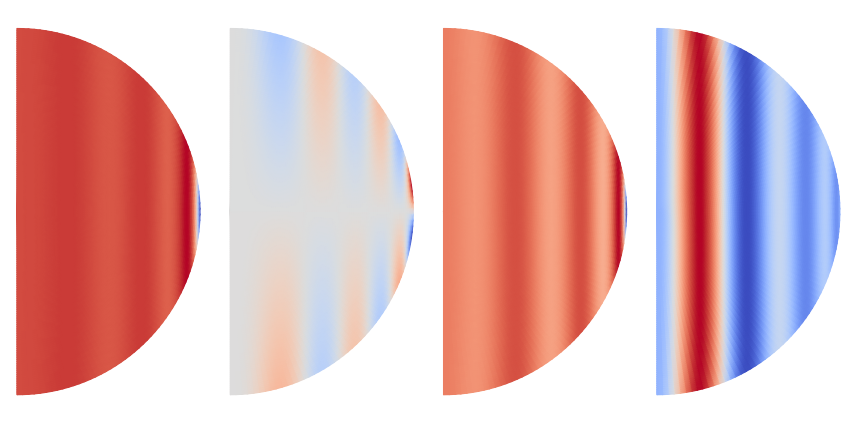

In [59]:
# plot_fields = [["U_s", "U_p", "U_z", "Zeta"],]
# plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$", r"$\zeta$"],]
plot_fields = [["Zeta", "U_z", "U_p", "U_s",],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$", r"$\zeta$"],]
save_name = None
save_name = "./out/cases/Malkus/Conjugate_recipe/mdplot_clean_inv"
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*6))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.real(eigmode_eval[fname]).max() > 1e-5:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            # plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            # plt.colorbar(cm, ax=ax)
        # if fname in core.pgvar._field_names:
        #     ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        # else:
        #     ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")
        ax.axis("off")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()